In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
import pickle #to download MLP vectors
import random

#plot
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import preprocessing_Origins, nbrh_WG_open, mid_cum_Z4_sec
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


2


In [6]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
dico_garden_opening_hour = config.dico_garden_opening_hour
id_run = config.id_run
date_consistent_barn_schedule = config.date_consistent_barn_schedule
dico_matching = config.dico_matching
print(id_run)

change the configuration file if not done yet!
ALLDATA_


In [ ]:
TODO: check if sunlight has 10mn delay backward or forward

# download data

In [9]:
#mvt data
df_daily = pd.read_csv(os.path.join(path_extracted_data, id_run+'_daily_ALL_variables.csv'), sep=';',
                 parse_dates=['level', 'FirstTimestamp_1_Zone', 'FirstTimestamp_2_Zone', 'FirstTimestamp_3_Zone',
                             'FirstTimestamp_4_Zone','FirstTimestamp_5_Zone'],
                 dayfirst=True) 
df_daily = df_daily[df_daily['level']!=dt.datetime(2021,7,25)]
print(df_daily.shape)
df_daily.head(3)

(39382, 70)


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Max_duration_zones,night_duration_Z5,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB
0,hen_130,2020-10-05,NaN,0.0,0.0,0.0,32400.0,32400.0,9.0,"[0.0, 0.0, 0.0, 0.0, 32400.0]",...,5_Zone,54000.0,0.0,0.0,9,True,124,18,6,1
1,hen_130,2020-10-06,NaN,0.0,780.0,325.0,31295.0,32400.0,9.0,"[0.0, 0.0, 780.0, 325.0, 31295.0]",...,3_Zone,5363.0,1.0,1.0,9,True,125,18,7,1
2,hen_130,2020-10-07,NaN,206.0,249.0,130.0,31815.0,32400.0,9.0,"[0.0, 206.0, 249.0, 130.0, 31815.0]",...,5_Zone,54000.0,0.0,0.0,9,True,126,18,8,2


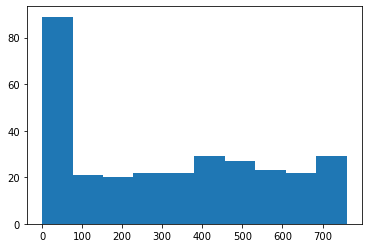

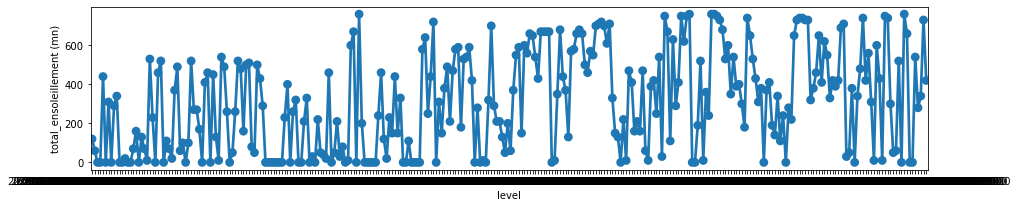

In [112]:
#Stimulus
path_ = r'G:\VPHI\Welfare\2- Research Projects\OFHE2.OriginsE2\DataOutput\order103345'
df = pd.read_csv(os.path.join(path_, 'order_103345_data.txt'), sep=';',
                 parse_dates=['time'],
                 dayfirst=True) 
df['level'] = df['time'].map(lambda x: dt.datetime(x.year, x.month, x.day))
df['time'] = df['time'].map(lambda x: dt.datetime.time(x))
#logically, 2h10 shuoldb be for 2h-2h10 as they will record once the data has arrived so lets take from 2h10 until 17h
df = df[(df['time']>dt.time(2,0,0))&(df['time']<=dt.time(17,0,0))]
print(min(df['level']), max(df['level']))
plt.hist(df['sre000z0'], bins=11);
plt.show();
print(df.shape)
df.head(3)

### add li_S
df_S = df.sort_values(['level','time']).copy()
display(df_S.head(3))
display(df_S.tail(3))
##10mn batch in the data: so repeat each elemtn to have the sitmulus at the second level
df_S['li_S'] = df_S['sre000z0'].map(lambda x: int(x>0)) #1 if >0 0 else
display(df_S['li_S'].value_counts())
df_S = df_S.groupby(['level'])['li_S'].agg(lambda x: list(np.repeat(x, 10*60))).reset_index()
df_S['nbr_val'] = df_S['li_S'].map(lambda x: len(x))
display(df_S['nbr_val'].value_counts())
print(54000/60/60)
df_S
display(df_S.head(3))
print(df_S.shape)
df_S['total_ensoleillement (mn)'] = df_S['li_S'].map(lambda x: sum(x)/60)
plt.hist(df_S['total_ensoleillement (mn)']);
plt.show()
plt.figure(figsize=(15,3))
sns.pointplot(x='level',y='total_ensoleillement (mn)', data=df_S, s=1);

## construct li_B: in wg or not

In [449]:
df_B = df_daily[(df_daily['level']>dt.datetime(2020,11,20))&(df_daily['level']<dt.datetime(2020,11,27))].copy()
df_B[['level','HenID','list_ZALL']].head(3)

,level,HenID,list_ZALL
50,2020-11-21,hen_131,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
51,2020-11-22,hen_131,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
52,2020-11-24,hen_131,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."


In [450]:
dico_Z_B = {-1:-1,1:1,2:0,3:0,4:0,5:0}
df_B['li_B_'] = df_B['list_ZALL'].map(lambda x: [dico_Z_B[i] for i in eval(x)])
df_B[['level','HenID','list_ZALL','li_B_']].head(3)

,level,HenID,list_ZALL,li_B_
50,2020-11-21,hen_131,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
51,2020-11-22,hen_131,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
52,2020-11-24,hen_131,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [454]:
def is_WG_open_basedonindex(x, config, epsi_open=0, epsi_close=20):
    '''from a timestamp value x, the dico_ (typically: dico_garden_opening_hour) and the date_first_opening_WG parameters, 
    it will output true if the WG is open, false otherwise.
    With the epsi_* parameters it allows to be more flexible with the true time of opening/closing'''
    
    dico_ = config.dico_garden_opening_hour
    date_first_opening_WG = config.date_first_opening_WG
    close_dates = config.close_dates
    
    #if no record return nan
    if pd.isnull(x)==True:
        return(np.nan)
    if (x<date_first_opening_WG) | (dt.datetime(x.year,x.month,x.day) in close_dates):
        return(False)
    if max(dico_.keys())<dt.datetime(x.year,x.month,x.day,0,0,0):
        print('ERROR: your \"dico_garden_opening_hour\" parameter does not include information for the date: %s'%str(x))
        sys.exit()
    else:
        #take info (i.e. values) of the dico_ key that represent the smallest date among all the date>=x:
        m = min([d for d in dico_.keys() if d>=dt.datetime(x.year,x.month,x.day,0,0,0)])
        #return the first index nd last index to be included starting at 2h!!
        return([(dico_[m]['start_h']-2)*60*60 + dico_[m]['start_m']*60, (dico_[m]['end_h']-2)*60*60 + dico_[m]['end_m']*60])
    
is_WG_open_basedonindex(dt.datetime(2020,11,12), config)

[28800, 52500]

In [463]:
dico_level_wgindex = {}
for d in set(df_B['level'].tolist()):
    dico_level_wgindex[d] = is_WG_open_basedonindex(d, config)
#dico_level_wgindex

In [464]:
df_B['li_B'] = df_B.apply(lambda x: [-1 if (i<=dico_level_wgindex[x['level']][0]) | \
                                     (i>=dico_level_wgindex[x['level']][1]) else x['li_B_'][i] for i in range(0,len(x['li_B_']))], axis=1)

## functions to compute behavioural tendency

In [465]:
def get_stimulusInfo(df_S, SID, print_Debug=False):
    '''IUntilA: until which index one could use after (incuding that number!!)
    IUntilB: until which index one could use before (incuding that number!!)'''
    #initialize output
    dico_IDS_dfinfo = {}
    li_IDS_nothing = []
    
    #loop over each row of the Stimulus dataframe
    for i in range(0, df_S.shape[0]):
        li_dico = []
        li_S = df_S.iloc[i]['li_S']
        IDS = df_S.iloc[i][SID]
        #if no stimulus that day return np.nan
        if sum(li_S)==0:
            li_IDS_nothing.append(IDS)
            #go to the next index without executing the below code
            continue            
            
        #extract list of all indexes of when the stimulus occured
        li_indexS = [i for i, x in enumerate(li_S) if x==1]
        
        #generate a dico with keys = periodID and values = list of indexs from that period
        #first flag by 1 each values that is a start of a new period
        li_newgroup = [1]+[0 if li_indexS[i]==(li_indexS[i-1]+1) else 1 for i in range(1,len(li_indexS))]
        #then do cumulative som of that list to have period ditinguish by numbers
        li_pidorder = np.cumsum(li_newgroup)
        dico_pid_liInd = {}
        for periodID in set(li_pidorder):
            #get all indexed where periodID occured
            li_pidindex = [i for i, x in enumerate(li_pidorder) if x==periodID]
            #extract associated S index
            dico_pid_liInd['p'+str(periodID)] = np.array(li_indexS)[li_pidindex]
    
        #extract usefull list
        li_AllLast = [i[-1] for i in dico_pid_liInd.values()]
        li_AllFirst = [i[0] for i in dico_pid_liInd.values()]
    
        for periodid,li_ind in dico_pid_liInd.items():
            
            #among li_AllLast values, the biggest that is smaller than IFirst
            IPrevious = max([i for i in li_AllLast if i<li_ind[0]]+[np.nan])
            #if IPrevious==np.nan, then 0 else IPrevious
            IUntilB = IPrevious + 1 #+1 because it shouldnt be included in the previous period
            if math.isnan(IPrevious)==True:
                 IUntilB = 0  
                            
            #among li_AllFirst values, the smallest that is bigger than ILast
            INext = min([i for i in li_AllFirst if i>li_ind[-1]]+[np.nan])
            #ifINext==np.nan, then len(li_S) else INext
            IUntilA = INext -1 #-1 because it shouldnt be included in the previous period
            if math.isnan(INext)==True:
                IUntilA = len(li_S)-1 #-1 as its an index, which start with 0
                            
            li_dico.append({** {'ID':periodid, 
                                'IFirst':li_ind[0],
                                'ILast':li_ind[-1], 
                                'IPrevious':IPrevious, 
                                'IUntilB':IUntilB, 
                                'INext':INext, 
                                'IUntilA':IUntilA,
                                'duration':len(li_ind)},
                            ** dict(df_S.iloc[i][li_SID])})        
        
        df_SInfo = pd.DataFrame(li_dico)
        if print_Debug:
            display(df_SInfo.head(3))
        dico_IDS_dfinfo[IDS] = df_SInfo
        
    return (dico_IDS_dfinfo, li_IDS_nothing)

In [466]:
def select_periods(dico_IDS_dfinfo, R_beforeThisS, R_afterThisS, R_beforeAnoS, R_afterAnoS, ET, print_Debug=False):
    ''' one row per period,level'''
    #initialise output
    li_df = []
    
    #for each stimulus ID
    for IDS, df_info in dico_IDS_dfinfo.items():
        
        li_dico = []
        #iterate over each of its period and flag with "selected = 1" the period that we want
        for i in range(0,df_info.shape[0]):
            X = df_info.iloc[i]
            
            #################### create list of index that we can use for random period (AFTER period) ####################
            #if nothing after at all the return empty list
            if X['IUntilA']==X['ILast']:
                IAfterindex = [np.nan]
                if print_Debug:
                    print('AFTER: \nIAfterindex = [np.nan]')
                    
            else:
                #what we have
                li_ = set(range(int(X['ILast'])+1, int(X['IUntilA'])+1)) #X['ILast']+1:should be included in the Bs, int(X['IUntilA'])+1: because until is included
                #what we are generally allowed, when no other occurences is to close (i.e. based on This period only)
                li_allowed = set(range(int(X['ILast'])+1+R_afterThisS[0], int(X['ILast'])+R_afterThisS[1]+1))
                #what we should remove due to other S occurence (i.e. based on another period)
                if math.isnan(X['INext'])==True:
                    li_toremove = set()
                else:
                    li_toremove = set(range(int(X['INext'])-R_beforeAnoS, int(X['INext'])+1))

                #intersection between what we have and what we are allowed to have
                IAfterindex = list(li_ & li_allowed)
                #remove element to close to other occurences
                IAfterindex = set(IAfterindex) - li_toremove
                if print_Debug:
                    print('AFTER: \nwhat we have:')
                    print(li_)
                    print('li_allowed (based on This period):')
                    print(li_allowed)                
                    print('li_toremove (based on Another period):')
                    print(li_toremove)

            #Note: below we use int() in the range() because 5.0 is a float for instance and cant go in the range 
            #################### create list of index that we can use for random period (BEFORE period) ####################
            #if nothing before at all the return empty list
            if X['IUntilB']==X['IFirst']:
                Ibeforeindex = [np.nan]
                if print_Debug:
                    print('BEFORE: \nIbeforeindex = [np.nan]')
                
            else:
                #what we have
                li_ = set(range(int(X['IUntilB']), int(X['IFirst']))) 
                #what we are generally allowed, when no other occurences is to close (i.e. based on This period only)
                li_allowed = set(range(int(X['IFirst'])-R_beforeThisS[1], int(X['IFirst'])-R_beforeThisS[0]))
                #what we should remove due to other S occurence (i.e. based on another period)
                if math.isnan(X['IPrevious'])==True:
                    li_toremove = set()
                else:
                    li_toremove = set(range(int(X['IPrevious']), int(X['IPrevious'])+R_afterAnoS+1))

                #intersection between what we have and what we are allowed to have
                Ibeforeindex = list(li_ & li_allowed)
                #remove element to close to other occurences
                Ibeforeindex = set(Ibeforeindex) - li_toremove
                
                if print_Debug:
                    print('BEFORE: \nwhat we have:')
                    print(li_)
                    print('li_allowed (based on This period):')
                    print(li_allowed)                
                    print('li_toremove (based on Another period):')
                    print(li_toremove)

            ################################################## Selection  ##################################################
            #selection if Exposure Time (ET) is smaller or equal to what we have under S and at least eitherafter or before.
            #Also, we want to compare thigns taht are comparable over different perio or SID, therefore we need to ensure 
            #that we can compute the mean of elements, and not having a single element only. We will set kind of
            #arbitrarely that we need at least 2*ET to have enuogh to compute a mean on "comparable" to another mean with more
            #units of time
            #can be 
            flag_selected = 1
            if ((len(Ibeforeindex)<ET*2) & (len(IAfterindex)<ET*2)) | (X['duration']<ET*2):
                flag_selected = 0
            ################################################# Save output  #################################################
            if len(Ibeforeindex)<ET*2:
                Ibeforeindex = [np.nan]
            if len(IAfterindex)<ET*2:
                IAfterindex = [np.nan]                
            li_dico.append({** {'selected':flag_selected, 'Ibeforeindex':Ibeforeindex, 'IAfterindex':IAfterindex},
                            ** dict(df_info.iloc[i])})        
        df_SInfo = pd.DataFrame(li_dico)
        if print_Debug:
            display(df_SInfo)
        df_SInfo['IDS'] = IDS
        li_df.append(df_SInfo)

    return (pd.concat(li_df))

In [490]:
def behavioural_tendency(li_B, ET, Nbr_random, Ibeforeindex, IAfterindex, IFirst, ILast, fake_sec=0):
    
    #initialise output values, each list will at the end be of size Nbr_random
    tFZ_ALL = []
    tFZ_ALL_FAKE = []
    li_res = []    
    
    #small test
    if Nbr_random%2!=0:
        #print('we will add one to Nbr_random to have an even number')
        Nbr_random = Nbr_random + 1
    #if ET*2<Nbr_random:
        #print('we will reduce your number of random samples to avoid sampling with repetition')
    
    #if we can use only one side, then we multiply the number of samples to choose randomly b2, as we will divid by 2 later
    #for each side (and becaus ein this situatin we want the full N! N*2/2=N :))
    if (len(IAfterindex)==1)|(len(Ibeforeindex)==1):
        Nbr_random = Nbr_random*2
    
    random.seed(1234)
    #extract the behaviour under S, N times
    li_StartindexPossibilities = list(range(IFirst,ILast+1-ET))
    li_todo = random.sample(li_StartindexPossibilities, min(len(li_StartindexPossibilities),Nbr_random))
    for i in li_todo:
        tFZ_ALL.append(sum(li_B[i+fake_sec:i+ET+fake_sec]))
        
    #extract the behaviour on the right with S absent, N/2 times if both side exist, else N
    if len(IAfterindex)!=1:
        IAfterindexF = min(IAfterindex)
        IAfterindexL = max(IAfterindex)
        li_StartindexPossibilities = list(range(IAfterindexF,IAfterindexL+1-ET))
        li_todo = random.sample(li_StartindexPossibilities, min(len(li_StartindexPossibilities),int(Nbr_random/2)))
        for i in li_todo:
            tFZ_ALL_FAKE.append(sum(li_B[i+fake_sec:i+ET+fake_sec]))
                
    #extract the behaviour on the left with S absent, N/2 times if both side exist, else N
    if len(Ibeforeindex)!=1:
        IbeforeindexF = min(Ibeforeindex)
        IbeforeindexL = max(Ibeforeindex)
        li_StartindexPossibilities = list(range(IbeforeindexF, IbeforeindexL+1-ET))
        li_todo = random.sample(li_StartindexPossibilities, min(len(li_StartindexPossibilities),int(Nbr_random/2)))
        for i in li_todo:
            tFZ_ALL_FAKE.append(sum(li_B[i+fake_sec:i+ET+fake_sec]))
            
    #generate list of index. if not same amount due to not enough sampling possibilities then just take the max numbers
    for i in range(0,min(len(tFZ_ALL),len(tFZ_ALL_FAKE))):
        if tFZ_ALL[i]+tFZ_ALL_FAKE[i]==0:
            li_res.append(0)
        else:
            li_res.append((tFZ_ALL[i]-tFZ_ALL_FAKE[i])/(tFZ_ALL[i]+tFZ_ALL_FAKE[i]))
    
    return (round(np.mean(li_res),3), li_res, tFZ_ALL, tFZ_ALL_FAKE)

## Debug and verification

In [393]:
#get the periods
li_dicotest = [{'level': dt.datetime(2020,7,12), 'HenID': 'hen_120', 'li_S': [0,0,1,0,0,0,0,0,0,0]},
               {'level': dt.datetime(2020,7,14), 'HenID': 'hen_120', 'li_S': [0,0,1,0,0,1,1,1,0,0]},
               {'level': dt.datetime(2020,7,13), 'HenID': 'hen_20', 'li_S':  [0,0,0,0,0,1,1,1,0,0]},
               {'level': dt.datetime(2020,8,1), 'HenID': 'hen_13', 'li_S':   [0,0,1,1,1,1,1,1,0,1]},
               {'level': dt.datetime(2020,9,1), 'HenID': 'hen_13', 'li_S':   [0,0,1,1,1,1,1,0,0,1]},
               {'level': dt.datetime(2020,10,1), 'HenID': 'hen_13', 'li_S':  [0,0,0,0,0,0,0,0,0,0]}]
df_test = pd.DataFrame(li_dicotest)
display(df_test)
dico_IDS_dfinfo, li_IDS_nothing = get_stimulusInfo(df_S=df_test, SID='level', print_Debug=True)
print(li_IDS_nothing)

,level,HenID,li_S
0,2020-07-12,hen_120,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,2020-07-14,hen_120,"[0, 0, 1, 0, 0, 1, 1, 1, 0, 0]"
2,2020-07-13,hen_20,"[0, 0, 0, 0, 0, 1, 1, 1, 0, 0]"
3,2020-08-01,hen_13,"[0, 0, 1, 1, 1, 1, 1, 1, 0, 1]"
4,2020-09-01,hen_13,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 1]"
5,2020-10-01,hen_13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,p1,2,2,NaN,0,NaN,9,1,2020-07-12


,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,p1,2,2,NaN,0,5.0,4,1,2020-07-14
1,p2,5,7,2.0,3,NaN,9,3,2020-07-14


,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,p1,5,7,NaN,0,NaN,9,3,2020-07-13


,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,p1,2,7,NaN,0,9.0,8,6,2020-08-01
1,p2,9,9,7.0,8,NaN,9,1,2020-08-01


,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,p1,2,6,NaN,0,9.0,8,5,2020-09-01
1,p2,9,9,6.0,7,NaN,9,1,2020-09-01


[Timestamp('2020-10-01 00:00:00')]


In [424]:
#select period and extract other relevant info for computation
#R_beforeThisS = (0,3): mean directly after (i.e.e the first second after, the second after and the third after)
df_Sinfo = select_periods(dico_IDS_dfinfo = dico_IDS_dfinfo, 
               R_beforeThisS = (0,3), R_afterThisS = (0,3), 
               R_beforeAnoS = 1, R_afterAnoS = 1, 
               ET=1, print_Debug=True)
#we dont care about getting into netagve number into li_allowed
df_Sinfo

AFTER: 
what we have:
{3, 4, 5, 6, 7, 8, 9}
li_allowed (based on This period):
{3, 4, 5}
li_toremove (based on Another period):
set()
BEFORE: 
what we have:
{0, 1}
li_allowed (based on This period):
{0, 1, -1}
li_toremove (based on Another period):
set()


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,0,"{0, 1}","{3, 4, 5}",p1,2,2,NaN,0,NaN,9,1,2020-07-12


AFTER: 
what we have:
{3, 4}
li_allowed (based on This period):
{3, 4, 5}
li_toremove (based on Another period):
{4, 5}
BEFORE: 
what we have:
{0, 1}
li_allowed (based on This period):
{0, 1, -1}
li_toremove (based on Another period):
set()
AFTER: 
what we have:
{8, 9}
li_allowed (based on This period):
{8, 9, 10}
li_toremove (based on Another period):
set()
BEFORE: 
what we have:
{3, 4}
li_allowed (based on This period):
{2, 3, 4}
li_toremove (based on Another period):
{2, 3}


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,0,"{0, 1}",[nan],p1,2,2,NaN,0,5.0,4,1,2020-07-14
1,1,[nan],"{8, 9}",p2,5,7,2.0,3,NaN,9,3,2020-07-14


AFTER: 
what we have:
{8, 9}
li_allowed (based on This period):
{8, 9, 10}
li_toremove (based on Another period):
set()
BEFORE: 
what we have:
{0, 1, 2, 3, 4}
li_allowed (based on This period):
{2, 3, 4}
li_toremove (based on Another period):
set()


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,1,"{2, 3, 4}","{8, 9}",p1,5,7,NaN,0,NaN,9,3,2020-07-13


AFTER: 
what we have:
{8}
li_allowed (based on This period):
{8, 9, 10}
li_toremove (based on Another period):
{8, 9}
BEFORE: 
what we have:
{0, 1}
li_allowed (based on This period):
{0, 1, -1}
li_toremove (based on Another period):
set()
AFTER: 
IAfterindex = [np.nan]
BEFORE: 
what we have:
{8}
li_allowed (based on This period):
{8, 6, 7}
li_toremove (based on Another period):
{8, 7}


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,1,"{0, 1}",[nan],p1,2,7,NaN,0,9.0,8,6,2020-08-01
1,0,[nan],[nan],p2,9,9,7.0,8,NaN,9,1,2020-08-01


AFTER: 
what we have:
{8, 7}
li_allowed (based on This period):
{8, 9, 7}
li_toremove (based on Another period):
{8, 9}
BEFORE: 
what we have:
{0, 1}
li_allowed (based on This period):
{0, 1, -1}
li_toremove (based on Another period):
set()
AFTER: 
IAfterindex = [np.nan]
BEFORE: 
what we have:
{8, 7}
li_allowed (based on This period):
{8, 6, 7}
li_toremove (based on Another period):
{6, 7}


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level
0,1,"{0, 1}",[nan],p1,2,6,NaN,0,9.0,8,5,2020-09-01
1,0,[nan],[nan],p2,9,9,6.0,7,NaN,9,1,2020-09-01


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level,IDS
0,0,"{0, 1}","{3, 4, 5}",p1,2,2,NaN,0,NaN,9,1,2020-07-12,2020-07-12
0,0,"{0, 1}",[nan],p1,2,2,NaN,0,5.0,4,1,2020-07-14,2020-07-14
1,1,[nan],"{8, 9}",p2,5,7,2.0,3,NaN,9,3,2020-07-14,2020-07-14
0,1,"{2, 3, 4}","{8, 9}",p1,5,7,NaN,0,NaN,9,3,2020-07-13,2020-07-13
0,1,"{0, 1}",[nan],p1,2,7,NaN,0,9.0,8,6,2020-08-01,2020-08-01
1,0,[nan],[nan],p2,9,9,7.0,8,NaN,9,1,2020-08-01,2020-08-01
0,1,"{0, 1}",[nan],p1,2,6,NaN,0,9.0,8,5,2020-09-01,2020-09-01
1,0,[nan],[nan],p2,9,9,6.0,7,NaN,9,1,2020-09-01,2020-09-01


In [396]:
li_dicotest = [{'level': dt.datetime(2020,7,12), 'HenID': 'hen_120', 'li_B': [0,0,1,1,1,0,0,0,0,0]},
               {'level': dt.datetime(2020,7,14), 'HenID': 'hen_120', 'li_B': [0,0,1,1,0,1,1,1,0,0]},
               {'level': dt.datetime(2020,7,13), 'HenID': 'hen_20', 'li_B':  [0,0,0,0,0,1,1,1,0,0]},
               {'level': dt.datetime(2020,8,1), 'HenID': 'hen_13', 'li_B':   [0,0,1,1,1,1,1,1,0,1]},
               {'level': dt.datetime(2020,9,1), 'HenID': 'hen_13', 'li_B':   [0,0,1,1,1,1,1,0,0,1]},
               {'level': dt.datetime(2020,10,1), 'HenID': 'hen_13', 'li_B':  [0,0,0,0,0,0,0,0,0,0]}]
df_B_TEST = pd.DataFrame(li_dicotest)
display(df_B_TEST)

,level,HenID,li_B
0,2020-07-12,hen_120,"[0, 0, 1, 1, 1, 0, 0, 0, 0, 0]"
1,2020-07-14,hen_120,"[0, 0, 1, 1, 0, 1, 1, 1, 0, 0]"
2,2020-07-13,hen_20,"[0, 0, 0, 0, 0, 1, 1, 1, 0, 0]"
3,2020-08-01,hen_13,"[0, 0, 1, 1, 1, 1, 1, 1, 0, 1]"
4,2020-09-01,hen_13,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 1]"
5,2020-10-01,hen_13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [423]:
#to check the actual index computation other examples are needed (todo)
df_ALL = pd.merge(df_Sinfo, df_B_TEST, on=SID, how='inner')
print(df_Sinfo.shape, df_B_TEST.shape, df_ALL.shape)
df_ALL = df_ALL[df_ALL['selected']==1]
display(df_ALL)
df_ALL['BT_index'] = df_ALL.apply(lambda x: behavioural_tendency(li_B=x['li_B'], ET=2, Nbr_random=10,
                                                                 Ibeforeindex=x['Ibeforeindex'],IAfterindex=x['IAfterindex'],
                                                                 IFirst=x['IFirst'], ILast=x['ILast']), axis=1)
df_ALL

(8, 13) (6, 3) (8, 15)


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level,IDS,HenID,li_B
2,1,[nan],"{8, 9}",p2,5,7,2.0,3,NaN,9,3,2020-07-14,2020-07-14,hen_120,"[0, 0, 1, 1, 0, 1, 1, 1, 0, 0]"
3,1,"{2, 3, 4}","{8, 9}",p1,5,7,NaN,0,NaN,9,3,2020-07-13,2020-07-13,hen_20,"[0, 0, 0, 0, 0, 1, 1, 1, 0, 0]"
4,1,"{0, 1}",[nan],p1,2,7,NaN,0,9.0,8,6,2020-08-01,2020-08-01,hen_13,"[0, 0, 1, 1, 1, 1, 1, 1, 0, 1]"
6,1,"{0, 1}",[nan],p1,2,6,NaN,0,9.0,8,5,2020-09-01,2020-09-01,hen_13,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 1]"


we will reduce your number of random samples to avoid sampling with repetition
we will reduce your number of random samples to avoid sampling with repetition
we will reduce your number of random samples to avoid sampling with repetition
we will reduce your number of random samples to avoid sampling with repetition


C:\Users\camil\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\camil\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level,IDS,HenID,li_B,BT_index
2,1,[nan],"{8, 9}",p2,5,7,2.0,3,NaN,9,3,2020-07-14,2020-07-14,hen_120,"[0, 0, 1, 1, 0, 1, 1, 1, 0, 0]","(nan, [], [2], [])"
3,1,"{2, 3, 4}","{8, 9}",p1,5,7,NaN,0,NaN,9,3,2020-07-13,2020-07-13,hen_20,"[0, 0, 0, 0, 0, 1, 1, 1, 0, 0]","(1.0, [1.0], [2], [0])"
4,1,"{0, 1}",[nan],p1,2,7,NaN,0,9.0,8,6,2020-08-01,2020-08-01,hen_13,"[0, 0, 1, 1, 1, 1, 1, 1, 0, 1]","(nan, [], [2, 2, 2, 2], [])"
6,1,"{0, 1}",[nan],p1,2,6,NaN,0,9.0,8,5,2020-09-01,2020-09-01,hen_13,"[0, 0, 1, 1, 1, 1, 1, 0, 0, 1]","(nan, [], [2, 2, 2], [])"


# Extract Behavioural tendency

In [468]:
#note: df_S could be at the level, or level-henid we dont care. but we will compute info needed to comptue the behavioural 
#tendency. We will do a adictioanry of dataframe for each row, where each datafrmae will have the info needed
display(df_S.head(3))
display(df_B.head(1))

,level,li_S,nbr_val,total_ensoleillement (mn),n
0,2020-01-10,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54000,120.0,54000
1,2020-01-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54000,60.0,54000
2,2020-01-12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",54000,0.0,54000


,HenID,level,duration_1_Zone,duration_2_Zone,duration_3_Zone,duration_4_Zone,duration_5_Zone,verification_daily_total_duration,verification_daily_total_nbr_hour,dur_values,...,night_Total_number_transition,is_mvt_night,nbr_h_per_day,correct_amount_of_hour,DOA,WOA,DIB,WIB,li_B_,li_B
50,hen_131,2020-11-21,1097.0,21511.0,24156.0,3951.0,3285.0,54000.0,15.0,"[1097.0, 21511.0, 24156.0, 3951.0, 3285.0]",...,0.0,0.0,15,True,171,25,53,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -..."


In [469]:
#TODO: check if li_S = li_B length BEFRE HAND
df_B['n'] = df_B['li_B'].map(lambda x: len(x))
display(df_B['n'].value_counts())
df_S['n'] = df_S['li_S'].map(lambda x: len(x))
display(df_S['n'].value_counts())

54000    766
Name: n, dtype: int64

54000    304
Name: n, dtype: int64

In [470]:
#get the periods
dico_IDS_dfinfo, li_IDS_nothing = get_stimulusInfo(df_S=df_S, SID='level')
print(len(li_IDS_nothing))

55


In [471]:
#select period and extract other relevant info for computation. One row per period,level
#R_beforeThisS = (0,3): mean directly after (i.e.e the first second after, the second after and the third after)
df_Sinfo = select_periods(dico_IDS_dfinfo = dico_IDS_dfinfo, 
                           R_beforeThisS = (20*60,65*60), R_afterThisS = (20*60,65*60), 
                           R_beforeAnoS = 10*60, R_afterAnoS = 20*60, 
                           ET=20*60)
print(df_Sinfo.shape)
display(df_Sinfo.head(3))

(791, 13)


,selected,Ibeforeindex,IAfterindex,ID,IFirst,ILast,IPrevious,IUntilB,INext,IUntilA,duration,level,IDS
0,1,"{16384, 16385, 16386, 16387, 16388, 16389, 163...",[nan],p1,18000,20999,NaN,0,21600.0,21599,3000,2020-01-10,2020-01-10
1,0,[nan],"{24600, 24601, 24602, 24603, 24604, 24605, 246...",p2,21600,23399,20999.0,21000,28200.0,28199,1800,2020-01-10,2020-01-10
2,0,"{24600, 24601, 24602, 24603, 24604, 24605, 246...",[nan],p3,28200,29999,23399.0,23400,31800.0,31799,1800,2020-01-10,2020-01-10


0    0.5
1    0.5
Name: selected, dtype: float64

(791, 13) (766, 73) (620, 85)
(310, 89)


,HenID,level,BT_index_all,BT_sun
155,hen_131,2020-11-21,"(0.44, [0, 0, 1.0, 1.0, 1.0, 0, 0, 1.0, 0, 0, ...",0.44
156,hen_134,2020-11-21,"(0.38, [0, 0, 1.0, 1.0, 0, 1.0, 0, 1.0, 0, 0, ...",0.38


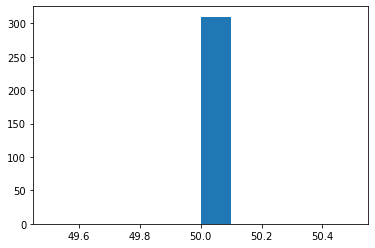

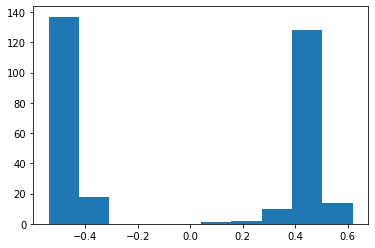

In [504]:
#compute behavioural tendency index
df_BT = pd.merge(df_Sinfo, df_B, on='level', how='inner')
display(df_BT['selected'].value_counts(normalize=True))
print(df_Sinfo.shape, df_B.shape, df_BT.shape)
df_BT = df_BT[df_BT['selected']==1]
df_BT['BT_index_all'] = df_BT.apply(lambda x: behavioural_tendency(li_B=x['li_B'], ET=2, Nbr_random=50,
                                                                 Ibeforeindex=x['Ibeforeindex'],IAfterindex=x['IAfterindex'],
                                                                 IFirst=x['IFirst'], ILast=x['ILast']), axis=1)
df_BT['BT_sun'] = df_BT['BT_index_all'].map(lambda x: x[0])
df_BT['BT_sun_lires'] = df_BT['BT_index_all'].map(lambda x: x[1])
df_BT['BT_sun_liresnbr'] = df_BT['BT_sun_lires'].map(lambda x: len(x))
print(df_BT.shape)
display(df_BT[['HenID', 'level','BT_index_all','BT_sun']].head(2))
plt.hist(df_BT['BT_sun_liresnbr']);
plt.show()
plt.hist(df_BT['BT_sun']);